In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.wkt import loads
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
JJ_path = '/content/drive/MyDrive/IPRO497_Demographic Team/Final/data/'
K_path = '/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Python Workspace/IIT Courses/TIF DS Project/Final/data/'

path = K_path

censusBlock = gpd.read_file(path + 'Boundaries - Census Blocks.geojson')
Community_area = gpd.read_file(path + 'Boundaries - Community Areas (current).geojson')

tifs = pd.read_csv(path + '2019_TIF_Boundaries.csv')
tifs = gpd.GeoDataFrame(tifs)
tifs = tifs.rename(columns={'the_geom': 'geometry'})
tifs['geometry'] = loads(tifs['geometry'])
tifs.set_geometry('geometry', inplace = True)

Blockgroup_boundary = pd.read_csv(path+'cleanBlockGroups.csv')
Blockgroup_boundary = Blockgroup_boundary.drop(columns=['coords'])

Blockgroup_race = pd.read_csv(path + 'Blockgroup_race_2010.csv', header=0)
# Blockgroup_race_2020 = pd.read_csv(path + 'Blockgroup_race_2020.csv', header=0)
Blockgroup_race = gpd.GeoDataFrame(Blockgroup_race)

In [3]:
prefix = '1500000US'
Blockgroup_boundary['geoid'] = prefix + Blockgroup_boundary['geoid'].astype(str)

print("total length of Blockgroup boundary : ", len(Blockgroup_boundary))

total length of Blockgroup boundary :  2194


In [4]:
Blockgroup_boundary.head(3)

,block group,tract,geoid,geometry
0,Group 1,101.0,1500000US170310101001,"POLYGON ((-87.6707199998406 42.02115399916493,..."
1,Group 2,101.0,1500000US170310101002,POLYGON ((-87.67215499997188 42.01937999993571...
2,Group 3,101.0,1500000US170310101003,POLYGON ((-87.66824299989591 42.01924399933382...


# 1. Preprocessing for demographic
- Cleans up the column name of the US Census data

In [5]:
Blockgroup_race.head(3)

,GEO_ID,NAME,P002001,P002002,P002003,P002004,P002005,P002006,P002007,P002008,...,P002065,P002066,P002067,P002068,P002069,P002070,P002071,P002072,P002073,Unnamed: 75
0,Geography,Geographic Area Name,Total,Total!!Hispanic or Latino,Total!!Not Hispanic or Latino,Total!!Not Hispanic or Latino!!Population of o...,Total!!Not Hispanic or Latino!!Population of o...,Total!!Not Hispanic or Latino!!Population of o...,Total!!Not Hispanic or Latino!!Population of o...,Total!!Not Hispanic or Latino!!Population of o...,...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,Total!!Not Hispanic or Latino!!Two or More Rac...,NaN
1,1500000US170310101001,"Block Group 1, Census Tract 101, Cook County, ...",579,121,458,440,245,168,1,21,...,0,0,0,0,0,0,0,0,0,NaN
2,1500000US170310101002,"Block Group 2, Census Tract 101, Cook County, ...",2311,248,2063,1986,343,1592,9,36,...,0,0,0,0,0,0,0,0,0,NaN


In [6]:
def preprocess_Race(beforepreprocessed):
  """
  delete unnecessary part of labels

  """

  beforepreprocessed.columns = beforepreprocessed.iloc[0]
  beforepreprocessed = beforepreprocessed.drop(0)
  beforepreprocessed.reset_index(drop=True, inplace=True)
  beforepreprocessed = beforepreprocessed.rename(columns={'Geography': 'geoid'})
  beforepreprocessed = beforepreprocessed.iloc[:, :-1]
  
  beforepreprocessed.columns = beforepreprocessed.columns.str.replace('!!Total:!!', '')
  beforepreprocessed.columns = beforepreprocessed.columns.str.replace('Total!!', '')

  beforepreprocessed['Geographic Area Name'] = beforepreprocessed["Geographic Area Name"].str.replace(', Cook County, Illinois', '')
  return beforepreprocessed

def get_blockgroup_racial_population(Blockgroup_race_information):
  """
  input : racial population for each census blockgroup
  output: total population, white population, black population, hispanic population for each census blockgroup

  """
  hispanic_column = Blockgroup_race_information.columns[3]
  #white_column = [Blockgroup_race.columns[6],Blockgroup_race.columns[14],Blockgroup_race.columns[15],Blockgroup_race.columns[16],Blockgroup_race.columns[17],Blockgroup_race.columns[18]]
  white_column = [Blockgroup_race_information.columns[6]]+ [Blockgroup_race_information.columns[column_name] for column_name in range(14,19)]
  #black_column = [Blockgroup_race.columns[7],Blockgroup_race.columns[19],Blockgroup_race.columns[20],Blockgroup_race.columns[21],Blockgroup_race.columns[22]]
  black_column = [Blockgroup_race_information.columns[7]]+[Blockgroup_race_information.columns[column_name] for column_name in range(19,23)]
  default_column = [Blockgroup_race_information.columns[0],Blockgroup_race_information.columns[1]]

  white_population_info = pd.concat([Blockgroup_race_information[default_column],Blockgroup_race_information[white_column].astype(np.int64).sum(axis=1)],axis=1)
  black_population_info = pd.concat([Blockgroup_race_information[default_column],Blockgroup_race_information[black_column].astype(np.int64).sum(axis=1)],axis=1)
  hispanic_population_info = pd.concat([Blockgroup_race_information[default_column],Blockgroup_race_information[hispanic_column].astype(np.int64)],axis=1)
  total_population_info = Blockgroup_race_information[white_column].astype(np.int64).sum(axis=1)+Blockgroup_race_information[black_column].astype(np.int64).sum(axis=1)+Blockgroup_race_information[hispanic_column].astype(np.int64)
  total_population_info = pd.concat([Blockgroup_race_information[default_column],total_population_info],axis=1)

  white_population_info = white_population_info.rename(columns={0:'White Population'})
  black_population_info = black_population_info.rename(columns={0:'Black Population'})
  hispanic_population_info = hispanic_population_info.rename(columns={'Hispanic or Latino':'Hispanic Population'})
  total_population_info = total_population_info.rename(columns={0:'Total Population'})

  racial_population_info = pd.merge(total_population_info, white_population_info)
  racial_population_info = pd.merge(racial_population_info, black_population_info)
  racial_population_info = pd.merge(racial_population_info, hispanic_population_info)

  def get_racial_population_list(row):
      return [row['Total Population'], row['White Population'], row['Black Population'], row['Hispanic Population']]

  racial_population_info['racial_population_list']=np.nan
  racial_population_info['racial_population_list'] = racial_population_info.apply(lambda row: get_racial_population_list(row), axis=1)

  return racial_population_info


Blockgroup_race=preprocess_Race(Blockgroup_race)

# Blockgroup_race_2020=preprocess_Race(Blockgroup_race_2020)

racial_population = get_blockgroup_racial_population(Blockgroup_race)

In [7]:
racial_population

,geoid,Geographic Area Name,Total Population,White Population,Black Population,Hispanic Population,racial_population_list
0,1500000US170310101001,"Block Group 1, Census Tract 101",550,257,172,121,"[550, 257, 172, 121]"
1,1500000US170310101002,"Block Group 2, Census Tract 101",2247,377,1622,248,"[2247, 377, 1622, 248]"
2,1500000US170310101003,"Block Group 3, Census Tract 101",1850,958,645,247,"[1850, 958, 645, 247]"
3,1500000US170310102011,"Block Group 1, Census Tract 102.01",1308,395,578,335,"[1308, 395, 578, 335]"
4,1500000US170310102012,"Block Group 2, Census Tract 102.01",3657,860,1495,1302,"[3657, 860, 1495, 1302]"
...,...,...,...,...,...,...,...
3988,1500000US170318439004,"Block Group 4, Census Tract 8439",632,17,614,1,"[632, 17, 614, 1]"
3989,1500000US170318439005,"Block Group 5, Census Tract 8439",859,43,799,17,"[859, 43, 799, 17]"
3990,1500000US170319800001,"Block Group 1, Census Tract 9800",0,0,0,0,"[0, 0, 0, 0]"
3991,1500000US170319801001,"Block Group 1, Census Tract 9801",0,0,0,0,"[0, 0, 0, 0]"


# 2. Combine racial population and Blockgroup geomtry

In [8]:
count = 0
for i in range(len(Blockgroup_boundary)):
    if  np.array(Blockgroup_boundary['geoid'])[i] in np.array(racial_population['geoid']):
        pass
    else:
        count += 1

racial_population_with_geometry = pd.merge(Blockgroup_boundary, racial_population, on='geoid', how='inner')

racial_population_with_geometry = racial_population_with_geometry.drop(columns=['Geographic Area Name'])

racial_population_with_geometry= gpd.GeoDataFrame(racial_population_with_geometry)

racial_population_with_geometry['geometry'] = loads(racial_population_with_geometry['geometry'])
racial_population_with_geometry.set_geometry('geometry', inplace = True)

In [9]:
racial_population.head(3)

,geoid,Geographic Area Name,Total Population,White Population,Black Population,Hispanic Population,racial_population_list
0,1500000US170310101001,"Block Group 1, Census Tract 101",550,257,172,121,"[550, 257, 172, 121]"
1,1500000US170310101002,"Block Group 2, Census Tract 101",2247,377,1622,248,"[2247, 377, 1622, 248]"
2,1500000US170310101003,"Block Group 3, Census Tract 101",1850,958,645,247,"[1850, 958, 645, 247]"


In [10]:
racial_population_with_geometry.head(3)

,block group,tract,geoid,geometry,Total Population,White Population,Black Population,Hispanic Population,racial_population_list
0,Group 1,101.0,1500000US170310101001,"POLYGON ((-87.67072 42.02115, -87.67072 42.021...",550,257,172,121,"[550, 257, 172, 121]"
1,Group 2,101.0,1500000US170310101002,"POLYGON ((-87.67215 42.01938, -87.67251 42.019...",2247,377,1622,248,"[2247, 377, 1622, 248]"
2,Group 3,101.0,1500000US170310101003,"POLYGON ((-87.66824 42.01924, -87.66824 42.019...",1850,958,645,247,"[1850, 958, 645, 247]"


# 3. From Community Level, get demographics

In [11]:
# First, let's take one community to test with. -> Use West Town
community_names = np.array(Community_area['community'])
community_name = 'WEST TOWN'
WT_idx = np.where(community_name == community_names)

Community_area.iloc[WT_idx]

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
24,WEST TOWN,0,127562904.597,0,24,24,0,0,55203.7186956,"MULTIPOLYGON (((-87.65686 41.91078, -87.65685 ..."


In [12]:
# Now, find the list of census block group that is overlapping with West Town
WT_geom = Community_area.iloc[WT_idx]['geometry'].iloc[0]

CBG_overlap_list = []
CBG_overlap_ratio_list = []

for index, CBG in enumerate(racial_population_with_geometry['geometry']):
    overlap_area = WT_geom.intersection(CBG).area
    if overlap_area/CBG.area >= 0.05: # 5% threshold
        # if overlapping
        CBG_overlap_list.append(racial_population_with_geometry['geoid'].iloc[index])
        CBG_overlap_ratio_list.append(overlap_area/CBG.area)

In [13]:
# Then, find the list of TIF that is overlapping with West Town

TIF_overlap_list = []

for index, tif in enumerate(tifs['geometry']):
    overlap_area = WT_geom.intersection(tif).area
    if overlap_area != 0:
        TIF_overlap_list.append(tifs['NAME'].iloc[index])

In [14]:
TIF_overlap_list

['Chicago/Kingsbury',
 'Humboldt Park',
 'River West',
 'Division/Homan',
 'Kinzie Industrial Corridor',
 'North Branch (South)']

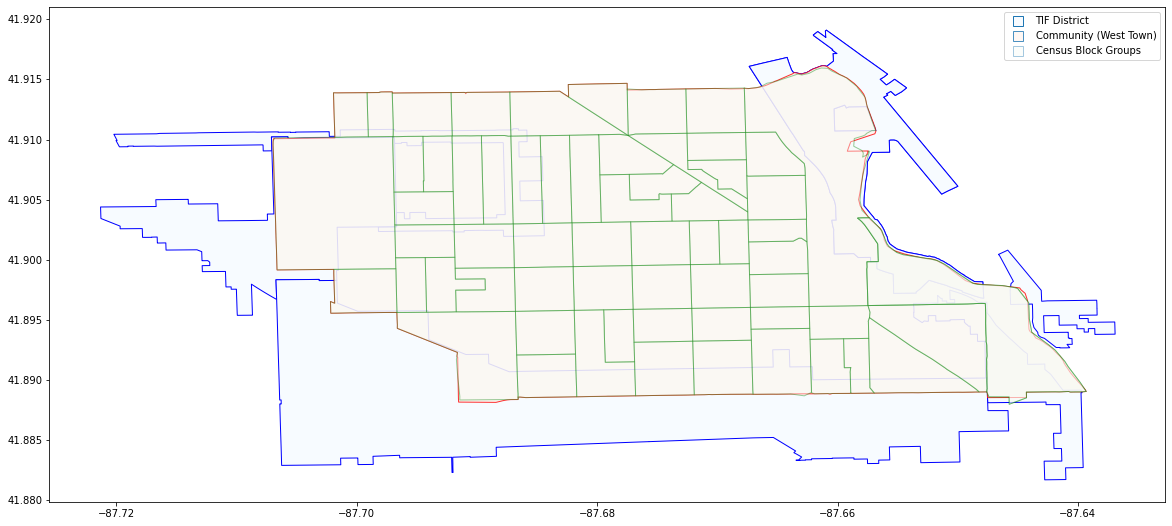

In [15]:
# Check on Map

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for tif_name in TIF_overlap_list:
    tifs[tifs['NAME'] == tif_name].plot(ax=ax, cmap="Blues", edgecolor="blue")

tifs[tifs['NAME'] == tif_name].plot(ax=ax, cmap="Blues", edgecolor="blue", label = 'TIF District')

Community_area[Community_area['community'] == community_name].plot(ax = ax, edgecolor = 'red', cmap = "Reds", alpha = 0.8, label = 'Community (West Town)')

for CBG_name in CBG_overlap_list:
    racial_population_with_geometry[racial_population_with_geometry['geoid'] == CBG_name].plot(ax = ax, edgecolor = 'green', cmap = "Greens", alpha = 0.4)

racial_population_with_geometry[racial_population_with_geometry['geoid'] == CBG_name].plot(ax = ax, edgecolor = 'green', cmap = "Greens", alpha = 0.4, label = 'Census Block Groups')

from matplotlib.lines import Line2D

lines = [
    Line2D([0], [0], linestyle="none", marker="s", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[1:]
]

labels = [t.get_label() for t in ax.collections[1:]]
ax.legend(lines, labels)


In [16]:
# For each TIF district that is overlapping with community, find associated census block groups for each one

inside_TIF_CBG_dict = {}
inside_TIF_CBG_ratio_dict = {}

for TIF_overlap in TIF_overlap_list:
    temp_list_geoid = []
    temp_list_area_ratio = []
    for CBG in CBG_overlap_list:
        CBG_geom = racial_population_with_geometry[racial_population_with_geometry['geoid'] == CBG]['geometry'].iloc[0]
        tif_geom = tifs[tifs['NAME'] == TIF_overlap]['geometry'].iloc[0]

        overlap_ratio = tif_geom.intersection(CBG_geom).intersection(WT_geom).area/CBG_geom.area
        if overlap_ratio != 0:
            # if overlapping
            temp_list_geoid.append(racial_population_with_geometry['geoid'].iloc[index])
            temp_list_area_ratio.append(overlap_ratio)
    inside_TIF_CBG_dict[TIF_overlap] = temp_list_geoid
    inside_TIF_CBG_ratio_dict[TIF_overlap] = temp_list_area_ratio

In [17]:
# Dataframe Columns : community name, community associated CBG, ratio of overlap for CBG, associated TIF, each TIF associated CBG & ratio

communities_df = pd.DataFrame(columns = ['Community', 'CBG in Community', 'CBG-Community Overlap', 'TIF in Community', 'CBG in TIF', 'CBG-Community-TIF Overlap'])

communities_df.loc[0] = [community_name, CBG_overlap_list, CBG_overlap_ratio_list, inside_TIF_CBG_dict.keys(), list(inside_TIF_CBG_dict.values()), list(inside_TIF_CBG_ratio_dict.values())]

In [18]:
communities_df

,Community,CBG in Community,CBG-Community Overlap,TIF in Community,CBG in TIF,CBG-Community-TIF Overlap
0,WEST TOWN,"[1500000US170312402001, 1500000US170312403001,...","[0.9946293955449089, 0.9973370412229249, 0.999...","(Chicago/Kingsbury, Humboldt Park, River West,...","[[1500000US170310314005], [1500000US1703103140...","[[0.018035602975798773], [0.028390644961490467..."


# Now, iterate for everything

In [32]:
for year in range(2017, 2023):
    try:
        # Iterate for all years
        tifs = pd.read_csv(path + str(year) + '_TIF_Boundaries.csv')
    except:
        tifs = pd.read_csv(path + str(year - 1) + '_TIF_Boundaries.csv')

    tifs.rename(columns= {'the_geom':'geometry'}, inplace = True)
    tifs = tifs.rename(columns={'the_geom': 'geometry'})
    tifs['geometry'] = loads(tifs['geometry'])
    tifs = tifs.set_geometry('geometry')
    
    # Now, iterate for all community
    community_names = np.array(Community_area['community'])
    communities_df = pd.DataFrame(columns = ['Community', 'CBG in Community', 'CBG-Community Overlap', 'TIF in Community', 'CBG in TIF', 'CBG-Community-TIF Overlap'])

    communities_df['Community'] = communities_df['Community'].astype(str)
    communities_df['CBG in Community'] = communities_df['CBG in Community'].astype(object)
    communities_df['CBG-Community Overlap'] = communities_df['CBG-Community Overlap'].astype(object)
    communities_df['TIF in Community'] = communities_df['TIF in Community'].astype(object)
    communities_df['CBG in TIF'] = communities_df['CBG in TIF'].astype(object)
    communities_df['CBG-Community-TIF Overlap'] = communities_df['CBG-Community-TIF Overlap'].astype(object)


    for iteration, community_name in enumerate(community_names):

        community_idx = np.where(community_name == community_names)

        Community_area.iloc[community_idx]

        # Now, find the list of census block group that is overlapping with West Town
        WT_geom = Community_area.iloc[community_idx]['geometry'].iloc[0]

        CBG_overlap_list = []
        CBG_overlap_ratio_list = []

        for index, CBG in enumerate(racial_population_with_geometry['geometry']):
            overlap_area = WT_geom.intersection(CBG).area
            if overlap_area/CBG.area >= 0.05: # 5% threshold
                # if overlapping
                CBG_overlap_list.append(racial_population_with_geometry['geoid'].iloc[index])
                CBG_overlap_ratio_list.append(overlap_area/CBG.area)

        # Then, find the list of TIF that is overlapping with West Town

        TIF_overlap_list = []

        for index, tif in enumerate(tifs['geometry']):
            overlap_area = WT_geom.intersection(tif).area
            if overlap_area != 0:
                TIF_overlap_list.append(tifs['NAME'].iloc[index])

        # For each TIF district that is overlapping with community, find associated census block groups for each one

        inside_TIF_CBG_dict = {}
        inside_TIF_CBG_ratio_dict = {}

        for TIF_overlap in TIF_overlap_list:

            temp_list_geoid = []
            temp_list_area_ratio = []

            for index, CBG in enumerate(CBG_overlap_list):
                CBG_geom = racial_population_with_geometry[racial_population_with_geometry['geoid'] == CBG]['geometry'].iloc[0]
                tif_geom = tifs[tifs['NAME'] == TIF_overlap]['geometry'].iloc[0]

                overlap_ratio = tif_geom.intersection(CBG_geom).intersection(WT_geom).area/CBG_geom.area
                if overlap_ratio != 0:
                    # if overlapping
                    temp_list_geoid.append(CBG)
                    temp_list_area_ratio.append(overlap_ratio)

            inside_TIF_CBG_dict[TIF_overlap] = temp_list_geoid
            inside_TIF_CBG_ratio_dict[TIF_overlap] = temp_list_area_ratio

            CBG_Community_Overlap = CBG_overlap_ratio_list
            TIF_in_Community = list(inside_TIF_CBG_dict.keys())
            CBG_in_TIF = list(inside_TIF_CBG_dict.values())
            CBG_Community_TIF_Overlap = list(inside_TIF_CBG_ratio_dict.values())

        communities_df.loc[iteration] = np.array([community_name, CBG_overlap_list, CBG_Community_Overlap, TIF_in_Community, CBG_in_TIF, CBG_Community_TIF_Overlap], dtype = 'object')


    # Perform for nonTIF
    community_names = np.array(Community_area['community'])
    non_TIF_df = pd.DataFrame(columns = ['Community', 'CBG in Community', 'CBG-Community Overlap', 'Non-TIF Ratio of CBG'])

    for iteration, community_name in enumerate(community_names):

        community_idx = np.where(community_name == community_names)
        Community_area.iloc[community_idx]

        # Now, find the list of census block group that is overlapping with West Town
        WT_geom = Community_area.iloc[community_idx]['geometry'].iloc[0]

        CBG_overlap_list = []
        CBG_overlap_ratio_list = []

        for index, CBG in enumerate(racial_population_with_geometry['geometry']):
            overlap_area = WT_geom.intersection(CBG).area
            if overlap_area/CBG.area >= 0.05: # 5% threshold
                # if overlapping
                CBG_overlap_list.append(racial_population_with_geometry['geoid'].iloc[index])
                CBG_overlap_ratio_list.append(overlap_area/CBG.area)
                
        # Get the list of TIF inside community
        related_TIF_names = communities_df[communities_df['Community'] == community_name]['TIF in Community'].iloc[0]

        # Then, find non-TIF ratio for each CBGb
        CBG_TIF_overlap_ratio_list = []

        for name in CBG_overlap_list:
            
            CBG = racial_population_with_geometry[racial_population_with_geometry['geoid'] == name]['geometry'].iloc[0].intersection(WT_geom)
            CBG_area = CBG.area

            for TIF_name in related_TIF_names:
                tif = tifs[tifs['NAME'] == TIF_name]['geometry'].iloc[0]

                if CBG.intersection(tif).area != 0:
                    CBG_area -= CBG.intersection(tif).area
            if CBG_area < 0:    
                CBG_area = 0
                
            non_overlap_ratio = CBG_area/CBG.area
            CBG_TIF_overlap_ratio_list.append(non_overlap_ratio)

        non_TIF_df.loc[iteration] = [community_name, CBG_overlap_list, CBG_overlap_ratio_list, CBG_TIF_overlap_ratio_list]

        demographics_df = pd.concat((communities_df, non_TIF_df['Non-TIF Ratio of CBG']), axis = 1)

        with open(path + 'DemographicsDataframe'+str(year)+'.pickle', 'wb') as file:
            pickle.dump(demographics_df, file)
        

In [5]:
demographics_df

,Community,CBG in Community,CBG-Community Overlap,TIF in Community,CBG in TIF,CBG-Community-TIF Overlap,Non-TIF Ratio of CBG
0,DOUGLAS,"[1500000US170313501001, 1500000US170313501002,...","[0.3705577340382647, 0.9918482746116661, 0.997...","[Pershing/King, 35th/State, 26th/King, 43rd/Co...","[[1500000US170313511002], [1500000US1703135150...","[[0.02034909003577528], [0.909004360882021, 0....","[0.38777640109670036, 0.48277184131174966, 0.7..."
1,OAKLAND,"[1500000US170313602001, 1500000US170318364001,...","[0.9914067780161118, 0.3497733270425202, 0.999...","[Drexel Boulevard, 43rd/Cottage Grove, Bronzev...","[[1500000US170318364003], [1500000US1703136020...","[[0.23548151922899832], [0.012168770147346799,...","[0.30096623416941903, 0.750543997010634, 0.944..."
2,FULLER PARK,"[1500000US170318355001, 1500000US170318355002,...","[0.9910261971449531, 0.9952102706448692, 0.993...","[35th/Wallace, 47th/Halsted, Stockyards Annex,...","[[1500000US170318355001], [1500000US1703183550...","[[4.309625519120923e-09], [0.278868509811505, ...","[0.17961872351092922, 0.3190509317800021, 0.25..."
3,GRAND BOULEVARD,"[1500000US170313801001, 1500000US170313802001,...","[0.9997554171799291, 0.999985445967372, 0.9999...","[Pershing/King, 41st/King, 49th/St Lawrence, 4...","[[1500000US170313801001, 1500000US170313802001...","[[4.60192502369363e-06, 0.8358741451376664, 0....","[5.739154045003963e-11, 0.010351352453321706, ..."
4,KENWOOD,"[1500000US170313901001, 1500000US170313902001,...","[0.5717969926585698, 0.9999999773452639, 0.999...","[53rd Street, 43rd/Cottage Grove, Washington P...","[[1500000US170313907001, 1500000US170313907002...","[[0.07280985837614108, 0.38668361011222435], [...","[1.0, 1.0, 1.0, 0.5188996940599669, 0.85092405..."
...,...,...,...,...,...,...,...
72,MOUNT GREENWOOD,"[1500000US170317401001, 1500000US170317401002,...","[0.9976439320149628, 0.9999999999999998, 1.0, ...","[111th/Kedzie, Western Avenue/Rock Island]","[[1500000US170317401003, 1500000US170317401004...","[[0.0018860302657678566, 0.1821327429759782, 0...","[0.8944659647779811, 0.9738955175540552, 0.918..."
73,MORGAN PARK,"[1500000US170317501001, 1500000US170317501002,...","[0.9998925117533687, 0.9999756540986596, 0.999...","[107th/Halsted, 119th & I-57 Redevelopment, We...","[[1500000US170317501001, 1500000US170317501002...","[[0.9995790325863747, 0.9986075104868779, 0.31...","[0.0, 0.0, 0.15290593890823673, 0.000760486334..."
74,OHARE,"[1500000US170317608011, 1500000US170317608012,...","[0.9998925117533687, 0.9999756540986596, 0.999...","[107th/Halsted, 119th & I-57 Redevelopment, We...","[[1500000US170317501001, 1500000US170317501002...","[[0.9995790325863747, 0.9986075104868779, 0.31...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
75,EDGEWATER,"[1500000US170310301011, 1500000US170310301012,...","[0.9999999999999998, 1.0, 1.0, 0.9999999999999...","[Edgewater/Ashland, Lawrence/Broadway, Bryn Ma...","[[1500000US170310304001, 1500000US170310304002...","[[0.04887290575728689, 0.1552887384443887], [0...","[0.8389431021815114, 1.0, 1.0, 1.0, 1.0, 0.602..."
